# Определение возраста покупателей

## Исследовательский анализ данных

In [ ]:
# Загружаем необходимые библиотеки для работы с изображениями
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
# Загрузка данных изображений
df = pd.read_csv('/datasets/faces/labels.csv')
# Первые строки датасета
display(df.head())
# Размер датасета
print(f'Размер датасета: {df.shape}\n')
# Общая информация о датасете
df.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Размер датасета: (7591, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


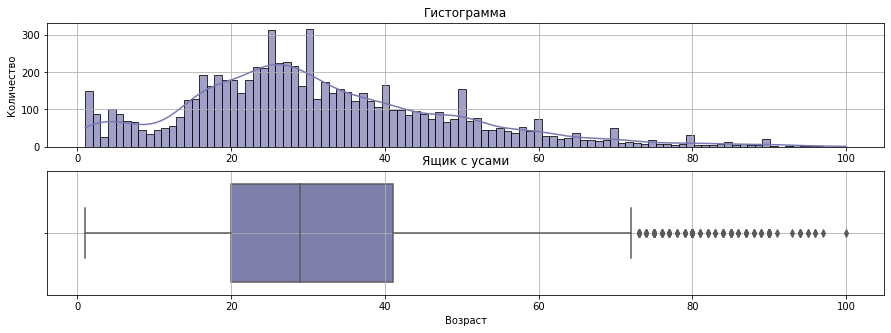

In [ ]:
# Построение графиков
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))
# построение гистограммы
sns.histplot(data=df,
             x='real_age',
             bins=100,
             kde=True,
             color='#7878b3',
             alpha=0.7,
             ax=ax1)
ax1.set_title('Гистограмма')
ax1.set_xlabel('')
ax1.set_ylabel('Количество')
ax1.grid(True)
# построение ящика с усами
sns.boxplot(data=df,
            x='real_age',
            orient='h',
            color='#7878b3',
            ax=ax2)
ax2.set_title('Ящик с усами')
ax2.set_xlabel('Возраст')
ax2.grid(True)
plt.show()

In [ ]:
# Параметры распределения
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [ ]:
# Создаем объект ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
# Извлекаем данные
datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


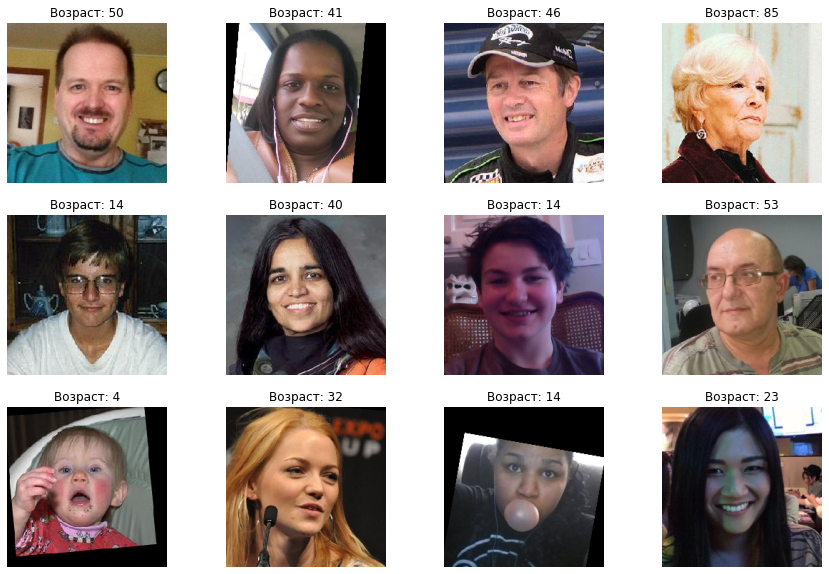

In [ ]:
# Вывод 10 изображений
features, target = next(datagen_flow)
fig, axes = plt.subplots(3, 4, figsize=(15,10))
for i, ax in enumerate(axes.flatten()):
    ax.set_title(f'Возраст: {target[i]}')
    ax.imshow(features[i])
    ax.axis('off')

**Вывод**

Всего в файле два столбца (file_name и real_age) и 7591 изображение. Возраст людей на фотографиях варьируется от 1 до 100 лет. Средний возраст 31 год. Чаще всего на фотографиях изображены люди возрастом от 20 до 40 лет.

Проблем в данных не выявлено, предобработка не требуется.

На исследование может повлять:
- разное разрешение фотографий;
- наличие непортретных фотографий (например, фото человека с достопримечательностью, где практически не видно лица или на изображении представлен профиль головы);
- наличие лишних предметов на фото.

## Обучение модели

Код обучения модели и её результат вывода на экран представлены ниже.

```python
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist

def load_train(path):
    '''Функция загрузки тренировочной выборки'''
    df = pd.read_csv(path+'labels.csv', engine='python')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       horizontal_flip=True,
                                       zoom_range=0.3,
                                       fill_mode='nearest',
                                       rotation_range = 90,
                                       rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(df,
                                                           directory=path+'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=16,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345)

    return train_datagen_flow

def load_test(path):
    '''Функция загрузки тестовой выборки'''
    df = pd.read_csv(path+'labels.csv', engine='python')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(df,
                                                         directory=path+'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=12345)

    return test_datagen_flow


def create_model(input_shape):
    '''Функция создания модели'''
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mae'])

    return model



def train_model(model,
                train_data,
                test_data,
                batch_size=None,
                epochs=10,
                steps_per_epoch=None,
                validation_steps=None):
    '''Функция обучения модели'''
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)

    return model
```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 139s - loss: 257.4588 - mae: 12.0271 - val_loss: 641.6213 - val_mae: 20.3024
Epoch 2/10
356/356 - 93s - loss: 143.7369 - mae: 9.1719 - val_loss: 146.0411 - val_mae: 9.1220
Epoch 3/10
356/356 - 93s - loss: 126.5028 - mae: 8.6706 - val_loss: 108.1540 - val_mae: 7.8693
Epoch 4/10
356/356 - 92s - loss: 113.7139 - mae: 8.1528 - val_loss: 111.2973 - val_mae: 8.1205
Epoch 5/10
356/356 - 92s - loss: 108.3596 - mae: 8.0000 - val_loss: 128.6139 - val_mae: 8.5074
Epoch 6/10
356/356 - 92s - loss: 98.7962 - mae: 7.5595 - val_loss: 86.1260 - val_mae: 7.0540
Epoch 7/10
356/356 - 92s - loss: 92.8251 - mae: 7.3984 - val_loss: 110.0627 - val_mae: 8.0969
Epoch 8/10
356/356 - 93s - loss: 87.0955 - mae: 7.1629 - val_loss: 86.8382 - val_mae: 7.0449
Epoch 9/10
356/356 - 92s - loss: 83.7453 - mae: 7.0192 - val_loss: 88.8855 - val_mae: 7.0577
Epoch 10/10
356/356 - 93s - loss: 80.6538 - mae: 6.8806 - val_loss: 108.4984 - val_mae: 7.4921

119/119 - 11s - loss: 108.4984 - mae: 7.4921
```

## Анализ обученной модели

В работе было разработана модель, которая по фотографии определит приблизительный возраст человека:

- Загрузка данных выполняется через ImageDataGenerator. Для изображений тренировочной выборки используются аугментации: горизонтальное отражение, масштабирование с методом заполнения новых пикселей, поворот на 90 градусов.
- Для работы выбрана предобученная модель ResNet50.
- В качестве функции активации принята ReLU: положительные прогнозы сети функция не меняет, а все отрицательные — приводит к нулю (так как возраста меньше 0 быть не может).
- В модели применяется функция потерь MSE и метрика MAE для оценки качества модели.
Метрика MAE на тестовой выборке за 10 эпох составила 7.5 (меньше требуемого значения 8).

Модель хорошо выполняет свои функции для анализа покупок и рекомендаций товаров, учитывая, что погрешность определения возраста клиентов составляет 7,5 лет. Но её использование для контроля продажи алкоголя может быть неэффективным. Такая погрешность велика для задач, требующих точного определения возраста, например, для предотвращения продажи алкоголя несовершеннолетним.


Для повышения точности определения возраста моделью рекомендуется:
- увеличить датасет: добавить изображения людей возрастом до 20 лет и от 50 лет;
- использовать более точную разметку изображений по возрасту: наблюдаются явные пики на гистограмме на возрастах, кратных 10 (возможно, возраст определялся "на глаз");
- исключить из датасета фотографии, на которых лица не являются основным объектом или плохо видны.